In [1]:
from transformers import AutoModel, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import our models. The package will take care of downloading the models automatically

model_id = "princeton-nlp/sup-simcse-roberta-large"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id).to(device)

/workspace/dpo/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/dpo/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/workspace/dpo/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# Sample Dataset for Testing
from datasets import load_dataset, VerificationMode

DATASET_SIZE = 960

dataset = load_dataset("mrcaelumn/yelp_restaurant_review_labelled", data_files={'test':'data/test-00000-of-00002-9007d2596358349d.parquet'}, split=f'test[:{DATASET_SIZE}]', verification_mode=VerificationMode.NO_CHECKS)
dataset.set_format(type="torch")

In [8]:
tokens = tokenizer(dataset['text'], padding=True, truncation=True, return_tensors="pt", max_length=512)

In [14]:
BATCH_SIZE = 32
NUM_BATCHES = DATASET_SIZE / BATCH_SIZE
assert NUM_BATCHES.is_integer(), "Batch size must be divisible by dataset size"

input_ids = tokens["input_ids"].to(device).reshape(-1,BATCH_SIZE, 512)
attention_mask = tokens["attention_mask"].to(device).reshape(-1, BATCH_SIZE, 512)

In [18]:
from tqdm import trange

embeddings = torch.zeros((DATASET_SIZE, 1024)).to(device)

with torch.no_grad():
    for i in trange(int(NUM_BATCHES)):
        output = model(input_ids=input_ids[i], attention_mask=attention_mask[i])
        embeddings[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = output.pooler_output

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


In [25]:
!python -m pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 41.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 65.2 MB/s eta 0:00:00:00:0100:01


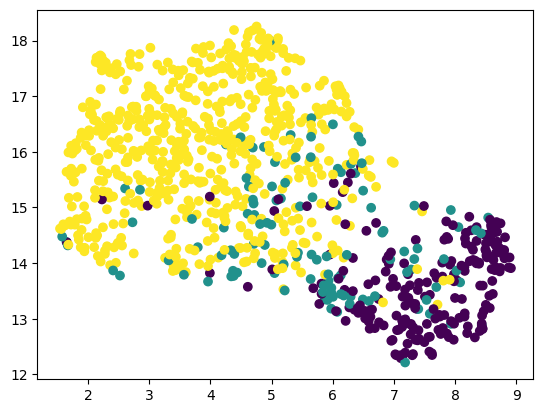

In [26]:
from umap import UMAP
from matplotlib import pyplot as plt

umap = UMAP(n_components=2)

embeddings_2d = umap.fit_transform(embeddings.cpu().numpy())

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=dataset['label'], cmap='viridis')
plt.show()

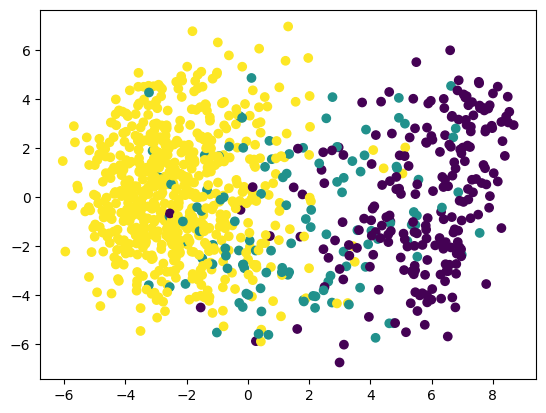

[0.12290079 0.0543163 ]


In [23]:
# from sklearn.decomposition import PCA
# from matplotlib import pyplot as plt

# pca = PCA(n_components=2)

# embeddings_2d = pca.fit_transform(embeddings.cpu().numpy())

# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=dataset['label'], cmap='viridis')
# plt.show()

# print(pca.explained_variance_ratio_)